# Acceptance analysis of Direct Air Capture and Storage

Documentation of the analysis.

## Overview and correlation matrix

In the first part, we compute certain mean values of groups of questions and plot the correlation matrix:

In [1]:
# uncomment the following lines to enable ../ in sys.path
import sys
import os

!pwd
sys.path.append(os.path.abspath("../"))


/Users/Torresj/Documents/gerics/dacstore/docs


In [ ]:

import numpy as np
import pandas as pd

import sys
import os

from dacstore.utils import ensure_floats, get_data
from dacstore.model import cronbach_alpha
from dacstore.config import replacer, weighting_groups
from dacstore.dac_analysis import (
    compute_group_averages,
    fix_agreement,
)
import seaborn as sns
import matplotlib.pyplot as plt

cols = [
    "climate_change_perception",
    "tampering_with_nature",
    "maturity_of_technology",
    "benefit_perception",
    "cost",
    "risk",
    "trust",
    "emotion",
    "distance",
    "dac_knowledge",
    "storage_knowledge",
    "initial_storage_support",
    "final_storage_support",
    "initial_dac_support",
    "final_dac_support",
    "age",
    "gender",
    "education",
    "occupation",
    "state",
]

independent = [
    "final_dac_support",
    "final_storage_support",
    "initial_storage_support",
    "initial_dac_support",
]


def create_numeric_data(df):
    """Create numeric data for regressions"""
    df = df.replace(replacer)
    df = fix_agreement(df)
    df = ensure_floats(df, weighting_groups)
    df = compute_group_averages(df, weighting_groups)
    return df

# read the raw data and print column names
df_raw = pd.read_csv("../data/data.csv")

print("Raw data columns:")
print(df_raw.columns)
print(f"Total entries in raw data: {len(df_raw)}")

# show unique collectors
print("Unique collectors in raw data:")
print(df_raw["Collector"].unique()) # ['Deutsche Post' 'Deutschland' 'GERICS' 'Bilendi']

# filter df_raw to only include rows where 'bilendi' in column 'Collector'
df_raw = df_raw[df_raw["Collector"] == "Bilendi"]
print(f"Filtered data to Bilendi only, resulting in {len(df_raw)} entries.")

# write to csv
df_raw.to_csv("../data/data_bilendi.csv", index=False)

# we work here with the original column names, no translation
# also, we replace no knowledge with neutral answers and drop invalid entries
df = get_data(
    source="../data/data_bilendi.csv",
    drop=True,
    translate=False,
    drop_invalid='no_attention', # one of True, False, 'no_speeding', 'no_straightlining', 'no_attention', 'no_incomplete'. False include incomplete entries (raw data).
    no_knowledge_to_neutral=True,
    set_dependent=True,
)

print("Data retrieved ...")
print(df.head())
print(df.columns)

# print total entries
print(f"Total entries in filtered data: {len(df)}")

# export filtered data to csv
df.to_csv("../data/data_bilendi_filtered.csv", index=False)

# filter by 

# an invalid entry (completed but more than 24hr completion time)
#df = df.drop(91621021) # excluded in Bilendi subset ====> TO DO: check if this is still needed or upgraded

# numerica data is created by replacing likert scales with numeric values
# and creating group averages for the weighting groups to create categorical data
df = create_numeric_data(df)

# we can filter the data here if needed according to some conditions # ===> TO DO: implement function to filter dataframe based on a condition
# df = post_filter(df, condition='1: All entries')

# we calculate the cronbach alpha for the weighting groups
# this should give an indication of how good our interrelated questions are correlated
cronbach = {
    group: cronbach_alpha(df[cols]).item()
    for group, cols in weighting_groups.items()
    if len(cols) > 1
}

# we drop the columns that are not in the weighting groups and not used in the regression
df = df[weighting_groups.keys()]
df = df[~df.isna().any(axis=1)]
df = df[cols]

# we need to drop the dependent variables from the independent variables
X = df[[c for c in df.columns if c not in independent]]

Raw data columns:
Index(['ID', 'Started on', 'Last updated on', 'Status', 'Collector',
       'Language', 'IP address', 'Device', 'Sind Sie einverstanden?',
       'Geschlecht', 'Altersgruppe', 'Höchster Bildungsabschluss', 'Beruf',
       'Bundesland',
       'Bitte bewerten Sie die folgenden Aussagen über den Klimawandel.',
       'Der Klimawandel findet tatsächlich statt.',
       'Der Klimawandel ist ein ernstes Problem.',
       'Menschliche Aktivitäten sind die Hauptursache des Klimawandels.',
       'Wir alle sollten uns bemühen, unseren CO2-Ausstoß zu reduzieren.',
       'Haben Sie schon von Technologien zur Entnahme von Kohlendioxid (CO2) aus der Luft (auf Englisch Direct Air Capture (DAC)) gehört?',
       'Wie gut sind ihre Kenntnisse dieser Technologien?',
       'Haben Sie schon von Kohlendioxid (CO2)-Speicherung gehört?',
       'Wie gut sind ihre Kenntnisse der CO2-Speicherungstechnologien?',
       'Unterstützen Sie die Einführung der folgenden Technologien?',
       '

/var/folders/dz/1rl43z597k11dq1sw2lhykf00000gp/T/ipykernel_5470/3885399375.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(replacer)


Let's check Cronbach alpha for our latent variables 

In [18]:
cronbach

{'climate_change_perception': 0.9006319468343957,
 'tampering_with_nature': 0.7781087017052859,
 'benefit_perception': 0.8089121920358754,
 'risk': 0.7811981535441868,
 'trust': 0.8869415881874771,
 'distance': 0.9034320882430507}

Let's have a look at the correlation matrix:

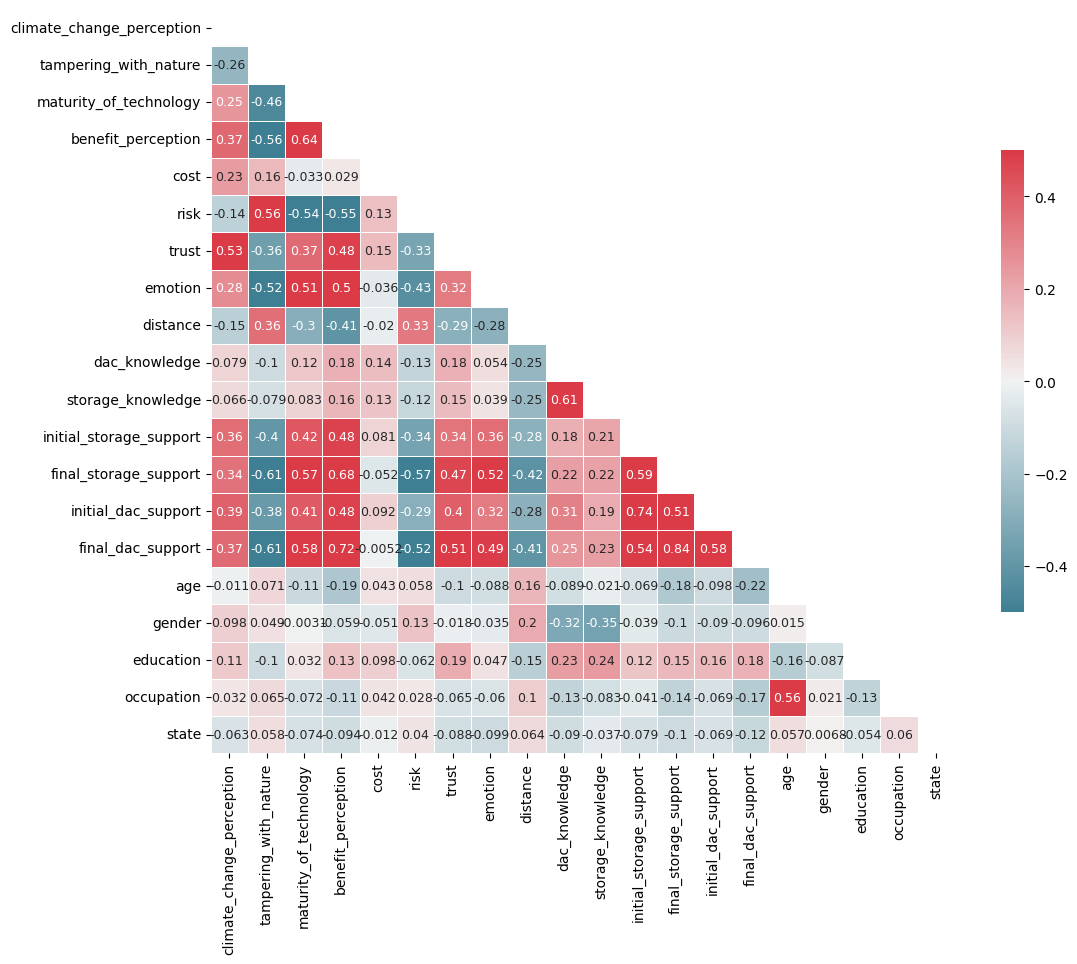

In [19]:
# Create the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# More details at https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(
    corr,  # The data to plot
    mask=mask,  # Mask some cells
    cmap=cmap,  # What colors to plot the heatmap as
    annot=True,  # Should the values be plotted in the cells?
    vmax=0.5,  # The maximum value of the legend. All higher vals will be same color
    vmin=-0.5,  # The minimum value of the legend. All lower vals will be same color
    center=0,  # The center value of the legend. With divergent cmap, where white is
    square=True,  # Force cells to be square
    linewidths=0.5,  # Width of lines that divide cells
    cbar_kws={
        "shrink": 0.5
    },  # Extra kwargs for the legend; in this case, shrink by 50%
    annot_kws={"fontsize": 9},
)

f.savefig("../results/correlation_matrix.png")
plt.show()
plt.close()

## Creating the models

In the first part, we check for multicollinearity to check for high correlation between independen variables:

In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_theme(color_codes=True)


def multicollinearity(X):
    """Check for multicollinearity"""
    # Check for multicollinearity using VIF
    X = sm.add_constant(X)  # Add a constant to the model (intercept)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_data


def create_ols_model(y, X):
    """Create an OLS model"""
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model


multicollinearity(X)

,feature,VIF
0,const,233.490102
1,climate_change_perception,1.575519
2,tampering_with_nature,1.934795
3,maturity_of_technology,1.970341
4,benefit_perception,2.454058
5,cost,1.179228
6,risk,1.876531
7,trust,1.714392
8,emotion,1.634018
9,distance,1.354404


This seems to be a good model, as all VIF values are below 5.0. Next, let's define our independent variables that we want to model. These are the final support of DAC after the survey was completed and the responders had all information they needed. We do the same investigation for the support of CO2 storage.

## DAC support

First, we create a model for the final DAC support.

In [21]:
y = df["final_dac_support"]
model = create_ols_model(y, X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      final_dac_support   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     127.2
Date:                Tue, 16 Sep 2025   Prob (F-statistic):          2.05e-237
Time:                        12:41:57   Log-Likelihood:                -1068.2
No. Observations:                1126   AIC:                             2170.
Df Residuals:                    1109   BIC:                             2256.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.4879      0.287      5.190      0.000       0.925       2.050
climate_change_perception     0.0685      0.026      2.605      0.009       0.017       0.120
tampering_with_nature        -0.2594      0.030     -8.763      0.000      -0.317      -0.201
maturity_of_technology        0.1566      0.030      5.139      0.000       0.097       0.216
benefit_perception            0.4615      0.039     11.955      0.000       0.386       0.537
cost                         -0.0196      0.023     -0.845      0.398      -0.065       0.026
risk                         -0.0713      0.042     -1.680      0.093      -0.155       0.012
trust                         0.1468      0.027      5.412      0.000       0.094       0.200
emotion                       0.0946      0.052      1.836      0.067      -0.007       0.196
distance                     -0.0323      0.021     -1.542      0.123      -0.073       0.009
dac_knowledge                 0.0669      0.028      2.420      0.016       0.013       0.121
storage_knowledge             0.0689      0.026      2.699      0.007       0.019       0.119
age                          -0.0536      0.015     -3.460      0.001      -0.084      -0.023
gender                       -0.0268      0.041     -0.648      0.517      -0.108       0.054
education                     0.0134      0.013      1.034      0.301      -0.012       0.039
occupation                   -0.0193      0.013     -1.474      0.141      -0.045       0.006
state                        -0.0061      0.004     -1.445      0.149      -0.014       0.002
==============================================================================
Omnibus:                       24.959   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.512
Skew:                          -0.160   Prob(JB):                     5.87e-10
Kurtosis:                       3.897   Cond. No.                         230.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation of OLS Regression Results for DAC Support

The OLS regression results provide insights into the factors influencing support for Direct Air Capture (DAC) of CO2 in the German population. Here is a detailed interpretation of the key metrics and coefficients:

#### Model Summary
- **R-squared: 0.656**: This indicates that approximately 65.6% of the variance in the dependent variable (`final_dac_support`) is explained by the independent variables in the model. This suggests a good fit.
- **Adjusted R-squared: 0.652**: This value adjusts for the number of predictors in the model and is slightly lower than the R-squared, indicating that the model is still a good fit after accounting for the number of predictors.
- **F-statistic: 166.8**: This tests the overall significance of the model. A high F-statistic value with a very low p-value (Prob (F-statistic): 4.45e-310) indicates that the model is statistically significant.
- **AIC: 2902 and BIC: 2991**: These are information criteria used for model selection. Lower values generally indicate a better-fitting model.

#### Coefficients and Significance
- **const (1.2052, p<0.0001)**: The intercept term, which represents the expected value of `final_dac_support` when all predictors are zero.
- **climate_change_perception (0.0763, p=0.003)**: A positive and significant coefficient, indicating that higher perception of climate change is associated with increased support for DAC.
- **tampering_with_nature (-0.2527, p<0.0001)**: A negative and highly significant coefficient, suggesting that concerns about tampering with nature are associated with decreased support for DAC.
- **maturity_of_technology (0.1022, p<0.0001)**: A positive and significant coefficient, indicating that perceptions of technology maturity are associated with increased support for DAC.
- **benefit_perception (0.5242, p<0.0001)**: A strong positive and highly significant coefficient, suggesting that higher perceived benefits are strongly associated with increased support for DAC.
- **cost (-0.0233, p=0.276)**: A negative but not statistically significant coefficient, indicating that perceived cost is not a strong predictor of DAC support.
- **risk (-0.0593, p=0.128)**: A negative but not statistically significant coefficient, suggesting that perceived risk is not a significant predictor of DAC support.
- **trust (0.1277, p<0.0001)**: A positive and significant coefficient, indicating that higher trust in institutions is associated with increased support for DAC.
- **emotion (0.2172, p<0.0001)**: A positive and significant coefficient, suggesting that emotional responses are associated with increased support for DAC.
- **distance (-0.0429, p=0.018)**: A negative and significant coefficient, indicating that greater perceived distance is associated with decreased support for DAC.
- **dac_knowledge (0.0796, p=0.002)**: A positive and significant coefficient, indicating that higher knowledge of DAC is associated with increased support.
- **storage_knowledge (0.0360, p=0.153)**: A positive but not statistically significant coefficient, suggesting that knowledge of CO2 storage is not a significant predictor of DAC support.
- **age (-0.0474, p=0.001)**: A negative and significant coefficient, indicating that older age is associated with decreased support for DAC.
- **gender (-0.0084, p=0.830)**: A negative but not statistically significant coefficient, suggesting that gender is not a significant predictor of DAC support.
- **education (0.0316, p=0.011)**: A positive and significant coefficient, indicating that higher education levels are associated with increased support for DAC.
- **occupation (-0.0177, p=0.166)**: A negative but not statistically significant coefficient, suggesting that occupation is not a significant predictor of DAC support.
- **state (-0.0074, p=0.057)**: A negative coefficient, close to being statistically significant, indicating that the state of residence may be associated with decreased support for DAC.

#### Diagnostic Metrics
- **Omnibus (30.436, p=0.000)**: Indicates that the residuals are not normally distributed.
- **Durbin-Watson (1.994)**: Close to 2, suggesting no significant autocorrelation in the residuals.
- **Jarque-Bera (51.270, p=7.36e-12)**: Indicates that the residuals are not normally distributed.
- **Skew (-0.166)**: Slightly negative skewness in the residuals.
- **Kurtosis (3.871)**: Slightly higher than 3, indicating heavier tails than a normal distribution.
- **Condition Number (217)**: Indicates potential multicollinearity issues if the value is high (generally above 30).

### Conclusion
The model explains a significant portion of the variance in support for DAC, with several predictors showing strong and significant relationships. Key factors influencing support include perceptions of climate change, tampering with nature, technology maturity, perceived benefits, trust, emotional responses, and knowledge of DAC. Some predictors, such as perceived cost, risk, and knowledge of CO2 storage, are not significant. The diagnostic metrics suggest that the model is statistically significant and provides a good fit for the data. Further investigation may be needed to address any potential issues with residual normality and multicollinearity.
```

### Additional statistical plots

We will plot some more statistics to get some insight into our data and check our assumption for linearity. In the following plots, we will plot the dependencies between our independent variable `final_dac_support` and the individual factors. Note that we jitter the data points to get a better visual interpretation of the likert scale.

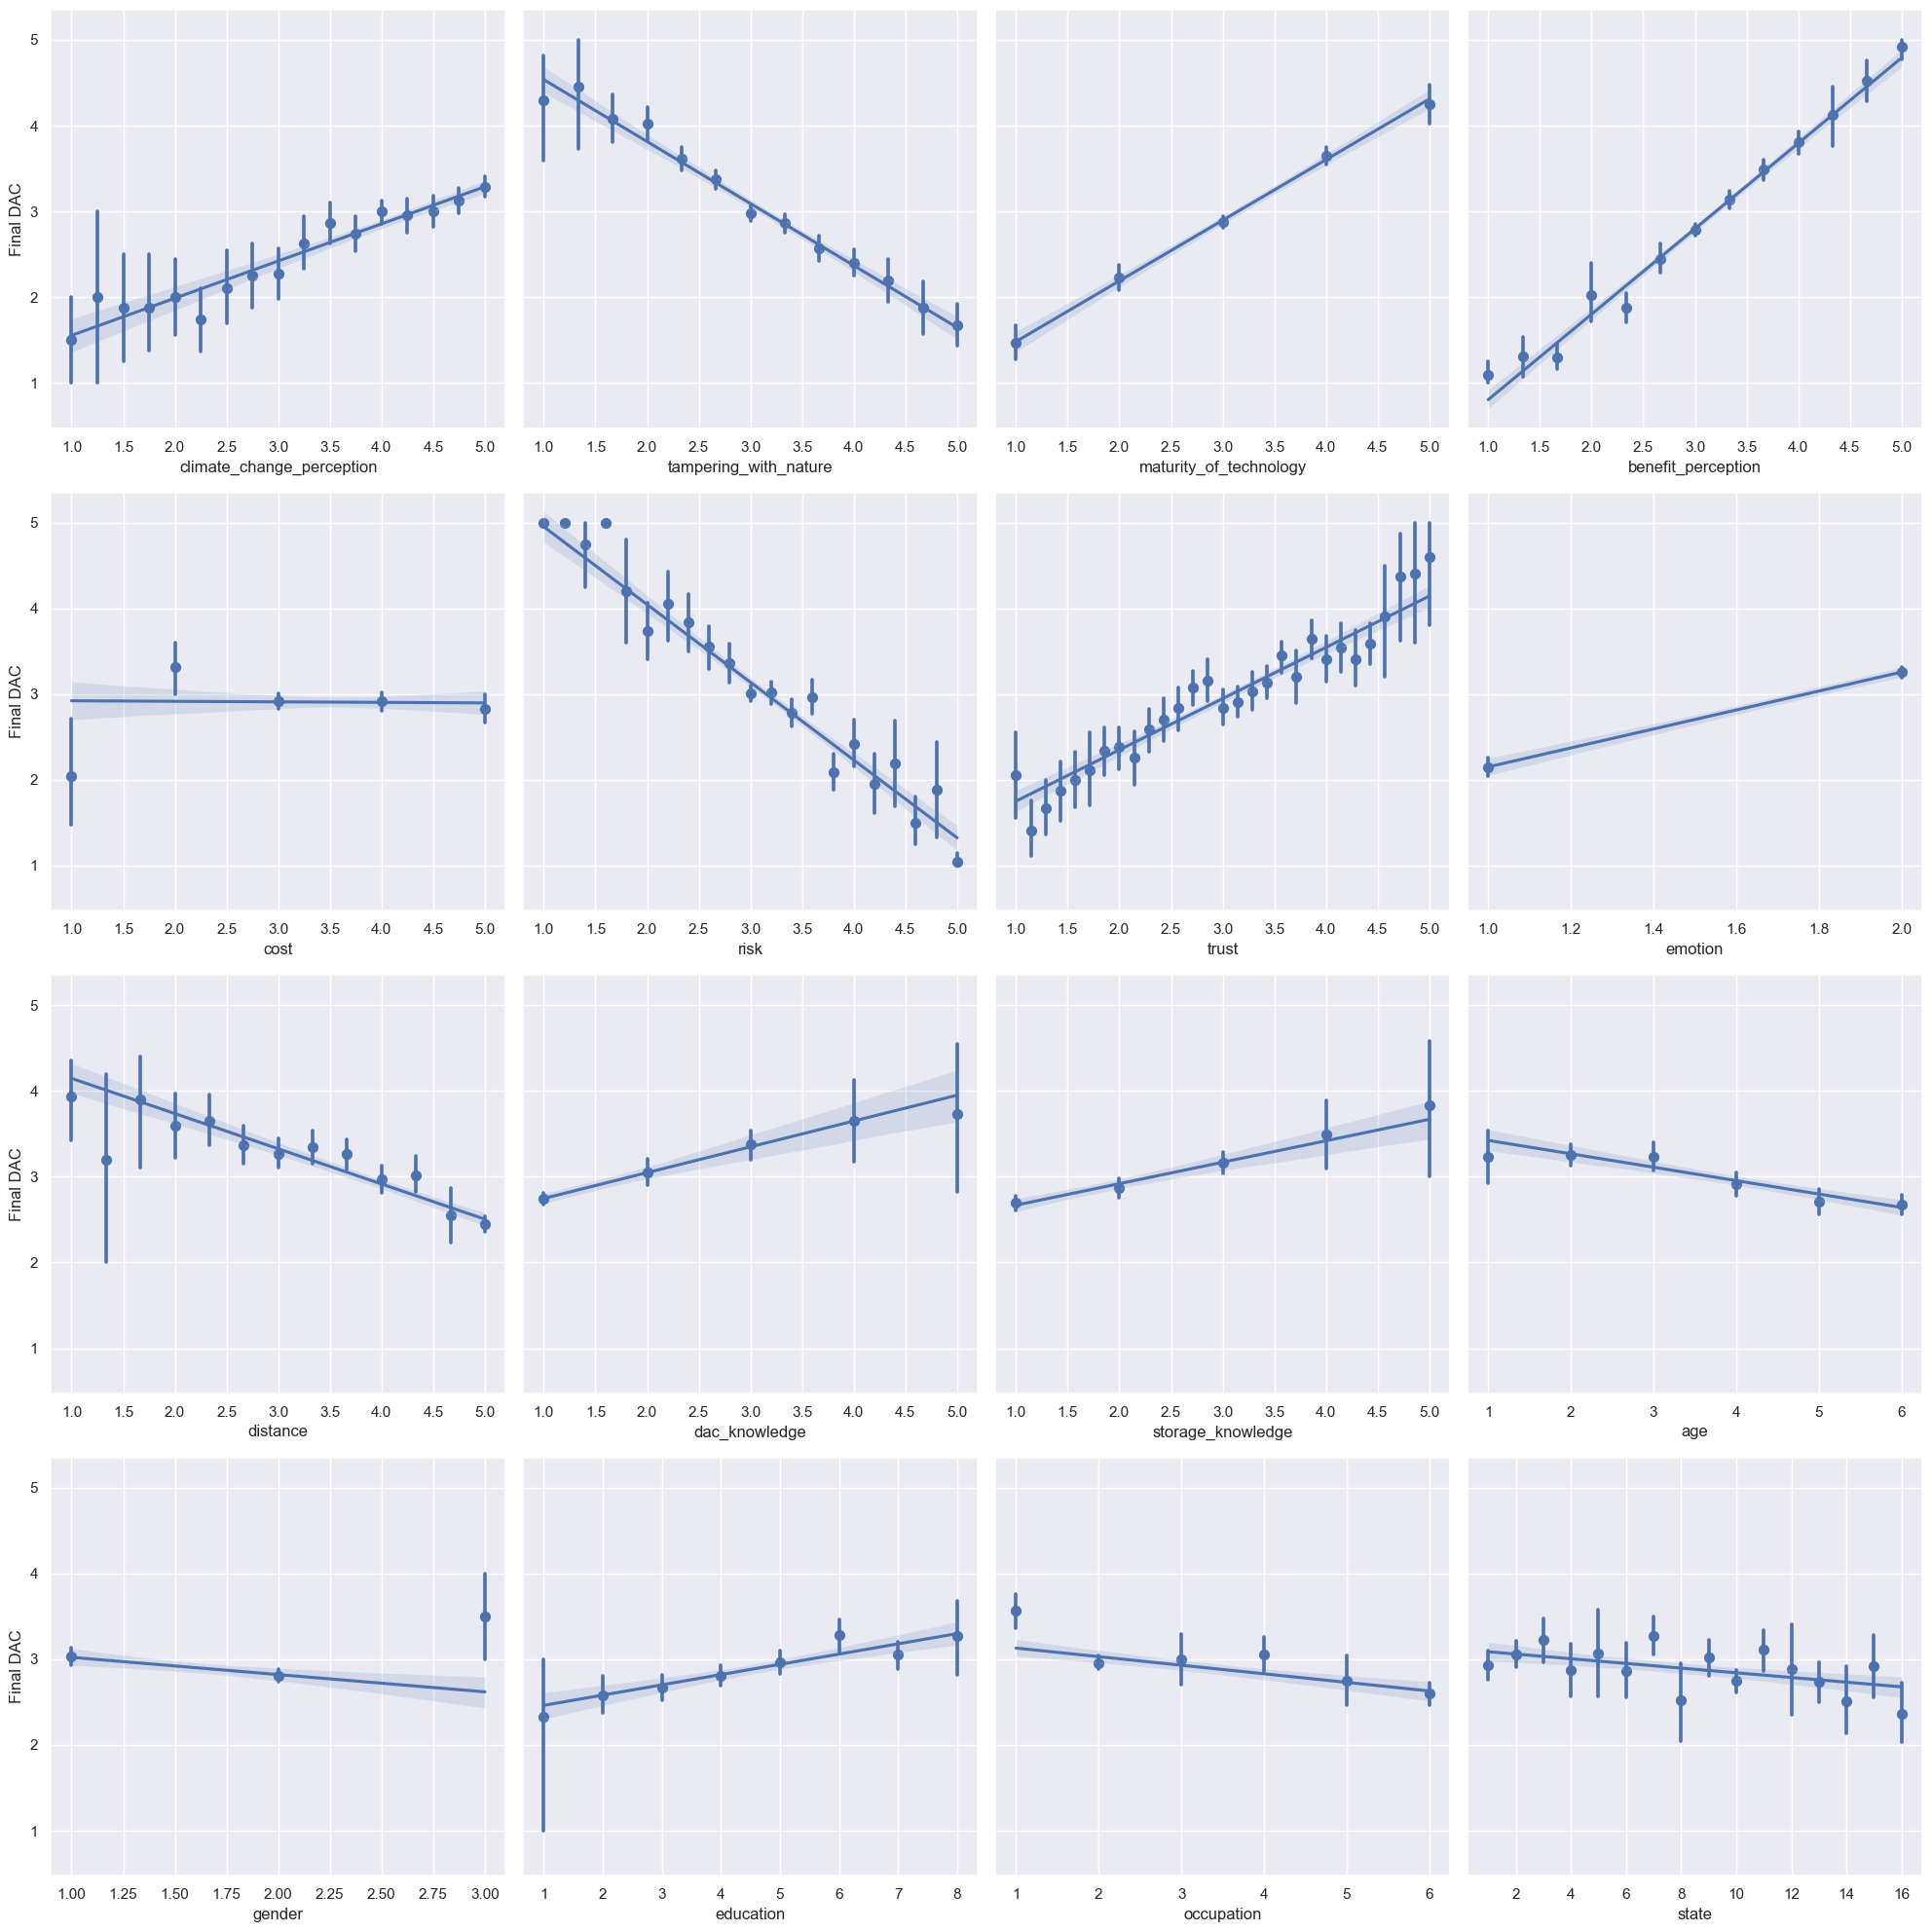

In [22]:
# Create a 4x4 panel plot
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharex=False, sharey=True)
axes = axes.flatten()

# Plot each scatter plot in the grid
for i, column in enumerate(X.columns):
    sns.regplot(
        y=df["final_dac_support"], x=df[column], x_estimator=np.mean, ax=axes[i]
    )
    if i % 4 == 0:
        axes[i].set_ylabel("Final DAC")
    else:
        axes[i].set_ylabel(None)

plt.tight_layout()
fig.savefig("../results/dac/final_dac_support_dependencies.png")
plt.show()
plt.close()

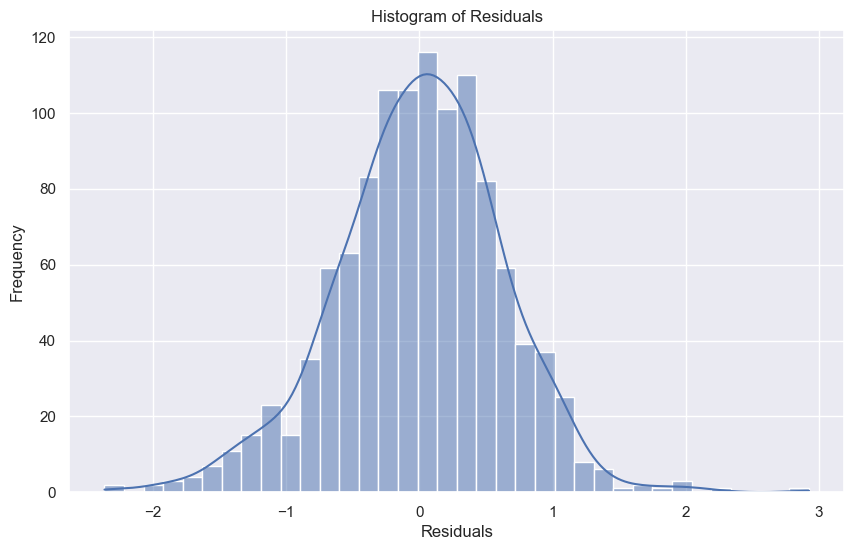

<Figure size 1000x600 with 0 Axes>

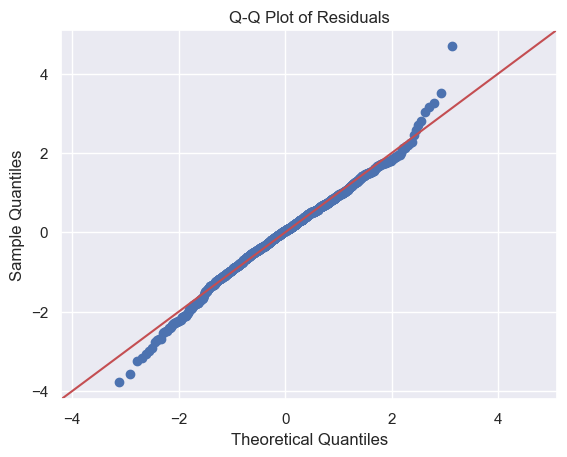

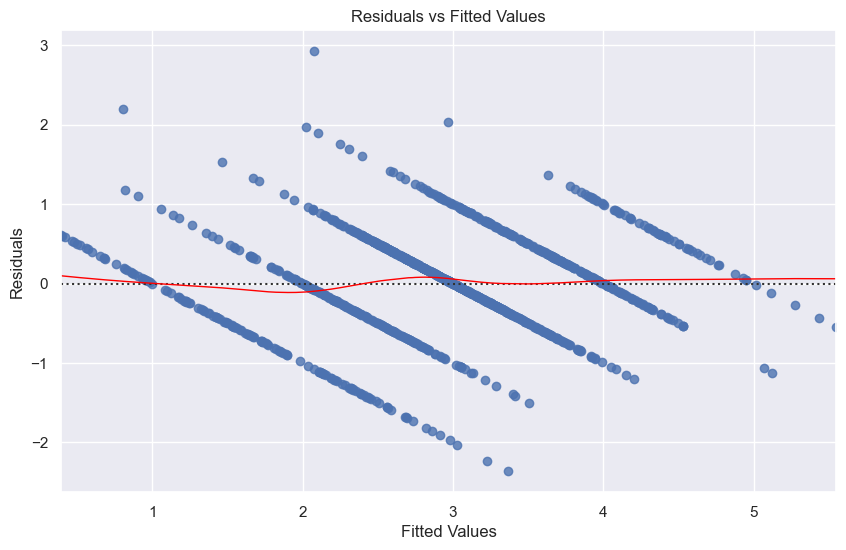

In [23]:
# Extract residuals
residuals = model.resid

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()
plt.savefig("../results/dac/residuals_histogram.png")
plt.close()

# Plot Q-Q plot of residuals
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line="45", fit=True)
plt.title("Q-Q Plot of Residuals")
plt.savefig("../results/dac/residuals_qq.png")
plt.show()
plt.close()

# Plot residuals vs fitted values
fitted_values = model.fittedvalues
plt.figure(figsize=(10, 6))
sns.residplot(
    x=fitted_values, y=residuals, lowess=True, line_kws={"color": "red", "lw": 1}
)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.savefig("../results/dac/residuals_vs_fitted.png")
plt.show()
plt.close()

## Support of CO2 storage

Now, we look at the final support of CO2 storage.

In [24]:
y = df["final_storage_support"]
model = create_ols_model(y, X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     final_storage_support   R-squared:                       0.616
Model:                               OLS   Adj. R-squared:                  0.610
Method:                    Least Squares   F-statistic:                     111.0
Date:                   Tue, 16 Sep 2025   Prob (F-statistic):          7.44e-217
Time:                           12:42:00   Log-Likelihood:                -1172.1
No. Observations:                   1126   AIC:                             2378.
Df Residuals:                       1109   BIC:                             2464.
Df Model:                             16                                         
Covariance Type:               nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.2567      0.314      7.177      0.000       1.640       2.874
climate_change_perception     0.0945      0.029      3.277      0.001       0.038       0.151
tampering_with_nature        -0.2412      0.032     -7.429      0.000      -0.305      -0.177
maturity_of_technology        0.1269      0.033      3.795      0.000       0.061       0.192
benefit_perception            0.3859      0.042      9.114      0.000       0.303       0.469
cost                         -0.0599      0.025     -2.357      0.019      -0.110      -0.010
risk                         -0.2470      0.047     -5.305      0.000      -0.338      -0.156
trust                         0.0927      0.030      3.115      0.002       0.034       0.151
emotion                       0.2353      0.057      4.162      0.000       0.124       0.346
distance                     -0.0665      0.023     -2.892      0.004      -0.112      -0.021
dac_knowledge                 0.0352      0.030      1.162      0.246      -0.024       0.095
storage_knowledge             0.0890      0.028      3.179      0.002       0.034       0.144
age                          -0.0345      0.017     -2.028      0.043      -0.068      -0.001
gender                       -0.0336      0.045     -0.739      0.460      -0.123       0.055
education                     0.0127      0.014      0.892      0.372      -0.015       0.041
occupation                   -0.0172      0.014     -1.197      0.231      -0.045       0.011
state                        -0.0038      0.005     -0.823      0.411      -0.013       0.005
==============================================================================
Omnibus:                       29.802   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.432
Skew:                          -0.282   Prob(JB):                     1.66e-09
Kurtosis:                       3.737   Cond. No.                         230.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation of OLS Regression Results for CO2 Storage Support

The OLS regression results provide insights into the factors influencing support for CO2 storage in the German population. Here is a detailed interpretation of the key metrics and coefficients:

#### Model Summary
- **R-squared: 0.632**: This indicates that approximately 63.2% of the variance in the dependent variable (`final_storage_support`) is explained by the independent variables in the model. This suggests a good fit.
- **Adjusted R-squared: 0.628**: This value adjusts for the number of predictors in the model and is slightly lower than the R-squared, indicating that the model is still a good fit after accounting for the number of predictors.
- **F-statistic: 150.2**: This tests the overall significance of the model. A high F-statistic value with a very low p-value (Prob (F-statistic): 1.17e-289) indicates that the model is statistically significant.
- **AIC: 3119 and BIC: 3209**: These are information criteria used for model selection. Lower values generally indicate a better-fitting model.

#### Coefficients and Significance
- **const (2.5420, p<0.0001)**: The intercept term, which represents the expected value of `final_storage_support` when all predictors are zero.
- **climate_change_perception (0.0994, p<0.0001)**: A positive and significant coefficient, indicating that higher perception of climate change is associated with increased support for CO2 storage.
- **tampering_with_nature (-0.2852, p<0.0001)**: A negative and highly significant coefficient, suggesting that concerns about tampering with nature are associated with decreased support for CO2 storage.
- **maturity_of_technology (0.0745, p=0.012)**: A positive and significant coefficient, indicating that perceptions of technology maturity are associated with increased support for CO2 storage.
- **benefit_perception (0.4060, p<0.0001)**: A strong positive and highly significant coefficient, suggesting that higher perceived benefits are strongly associated with increased support for CO2 storage.
- **cost (-0.0418, p=0.070)**: A negative coefficient, close to being statistically significant, indicating that higher perceived cost may be associated with decreased support for CO2 storage.
- **risk (-0.2858, p<0.0001)**: A negative and highly significant coefficient, suggesting that higher perceived risk is associated with decreased support for CO2 storage.
- **trust (0.0735, p=0.009)**: A positive and significant coefficient, indicating that higher trust in institutions is associated with increased support for CO2 storage.
- **emotion (0.2643, p<0.0001)**: A positive and significant coefficient, suggesting that emotional responses are associated with increased support for CO2 storage.
- **distance (-0.0826, p<0.0001)**: A negative and significant coefficient, indicating that greater perceived distance is associated with decreased support for CO2 storage.
- **dac_knowledge (0.0123, p=0.650)**: A positive but not statistically significant coefficient, suggesting that knowledge of DAC is not a significant predictor of CO2 storage support.
- **storage_knowledge (0.0936, p=0.001)**: A positive and significant coefficient, indicating that higher knowledge of CO2 storage is associated with increased support.
- **age (-0.0362, p=0.022)**: A negative and significant coefficient, indicating that older age is associated with decreased support for CO2 storage.
- **gender (0.0035, p=0.934)**: A positive but not statistically significant coefficient, suggesting that gender is not a significant predictor of CO2 storage support.
- **education (0.0171, p=0.198)**: A positive but not statistically significant coefficient, indicating that education level is not a strong predictor of CO2 storage support.
- **occupation (-0.0182, p=0.187)**: A negative but not statistically significant coefficient, suggesting that occupation is not a significant predictor of CO2 storage support.
- **state (0.0004, p=0.925)**: A positive but not statistically significant coefficient, indicating that the state of residence is not a strong predictor of CO2 storage support.

#### Diagnostic Metrics
- **Omnibus (38.286, p=0.000)**: Indicates that the residuals are not normally distributed.
- **Durbin-Watson (1.964)**: Close to 2, suggesting no significant autocorrelation in the residuals.
- **Jarque-Bera (50.948, p=8.64e-12)**: Indicates that the residuals are not normally distributed.
- **Skew (-0.299)**: Slightly negative skewness in the residuals.
- **Kurtosis (3.711)**: Slightly higher than 3, indicating heavier tails than a normal distribution.
- **Condition Number (217)**: Indicates potential multicollinearity issues if the value is high (generally above 30).

### Conclusion
The model explains a significant portion of the variance in support for CO2 storage, with several predictors showing strong and significant relationships. Key factors influencing support include perceptions of climate change, tampering with nature, technology maturity, perceived benefits, perceived risk, trust, emotional responses, and perceived distance. Some predictors, such as knowledge of DAC, gender, education, occupation, and state of residence, are not significant. The diagnostic metrics suggest that the model is statistically significant and provides a good fit for the data. Further investigation may be needed to address any potential issues with residual normality and multicollinearity.
```

### Additional statistical plots

We will plot some more statistics to get some insight into our data and check our assumption for linearity. In the following plots, we will plot the dependencies between our independent variable `final_storage_support` and the individual factors.

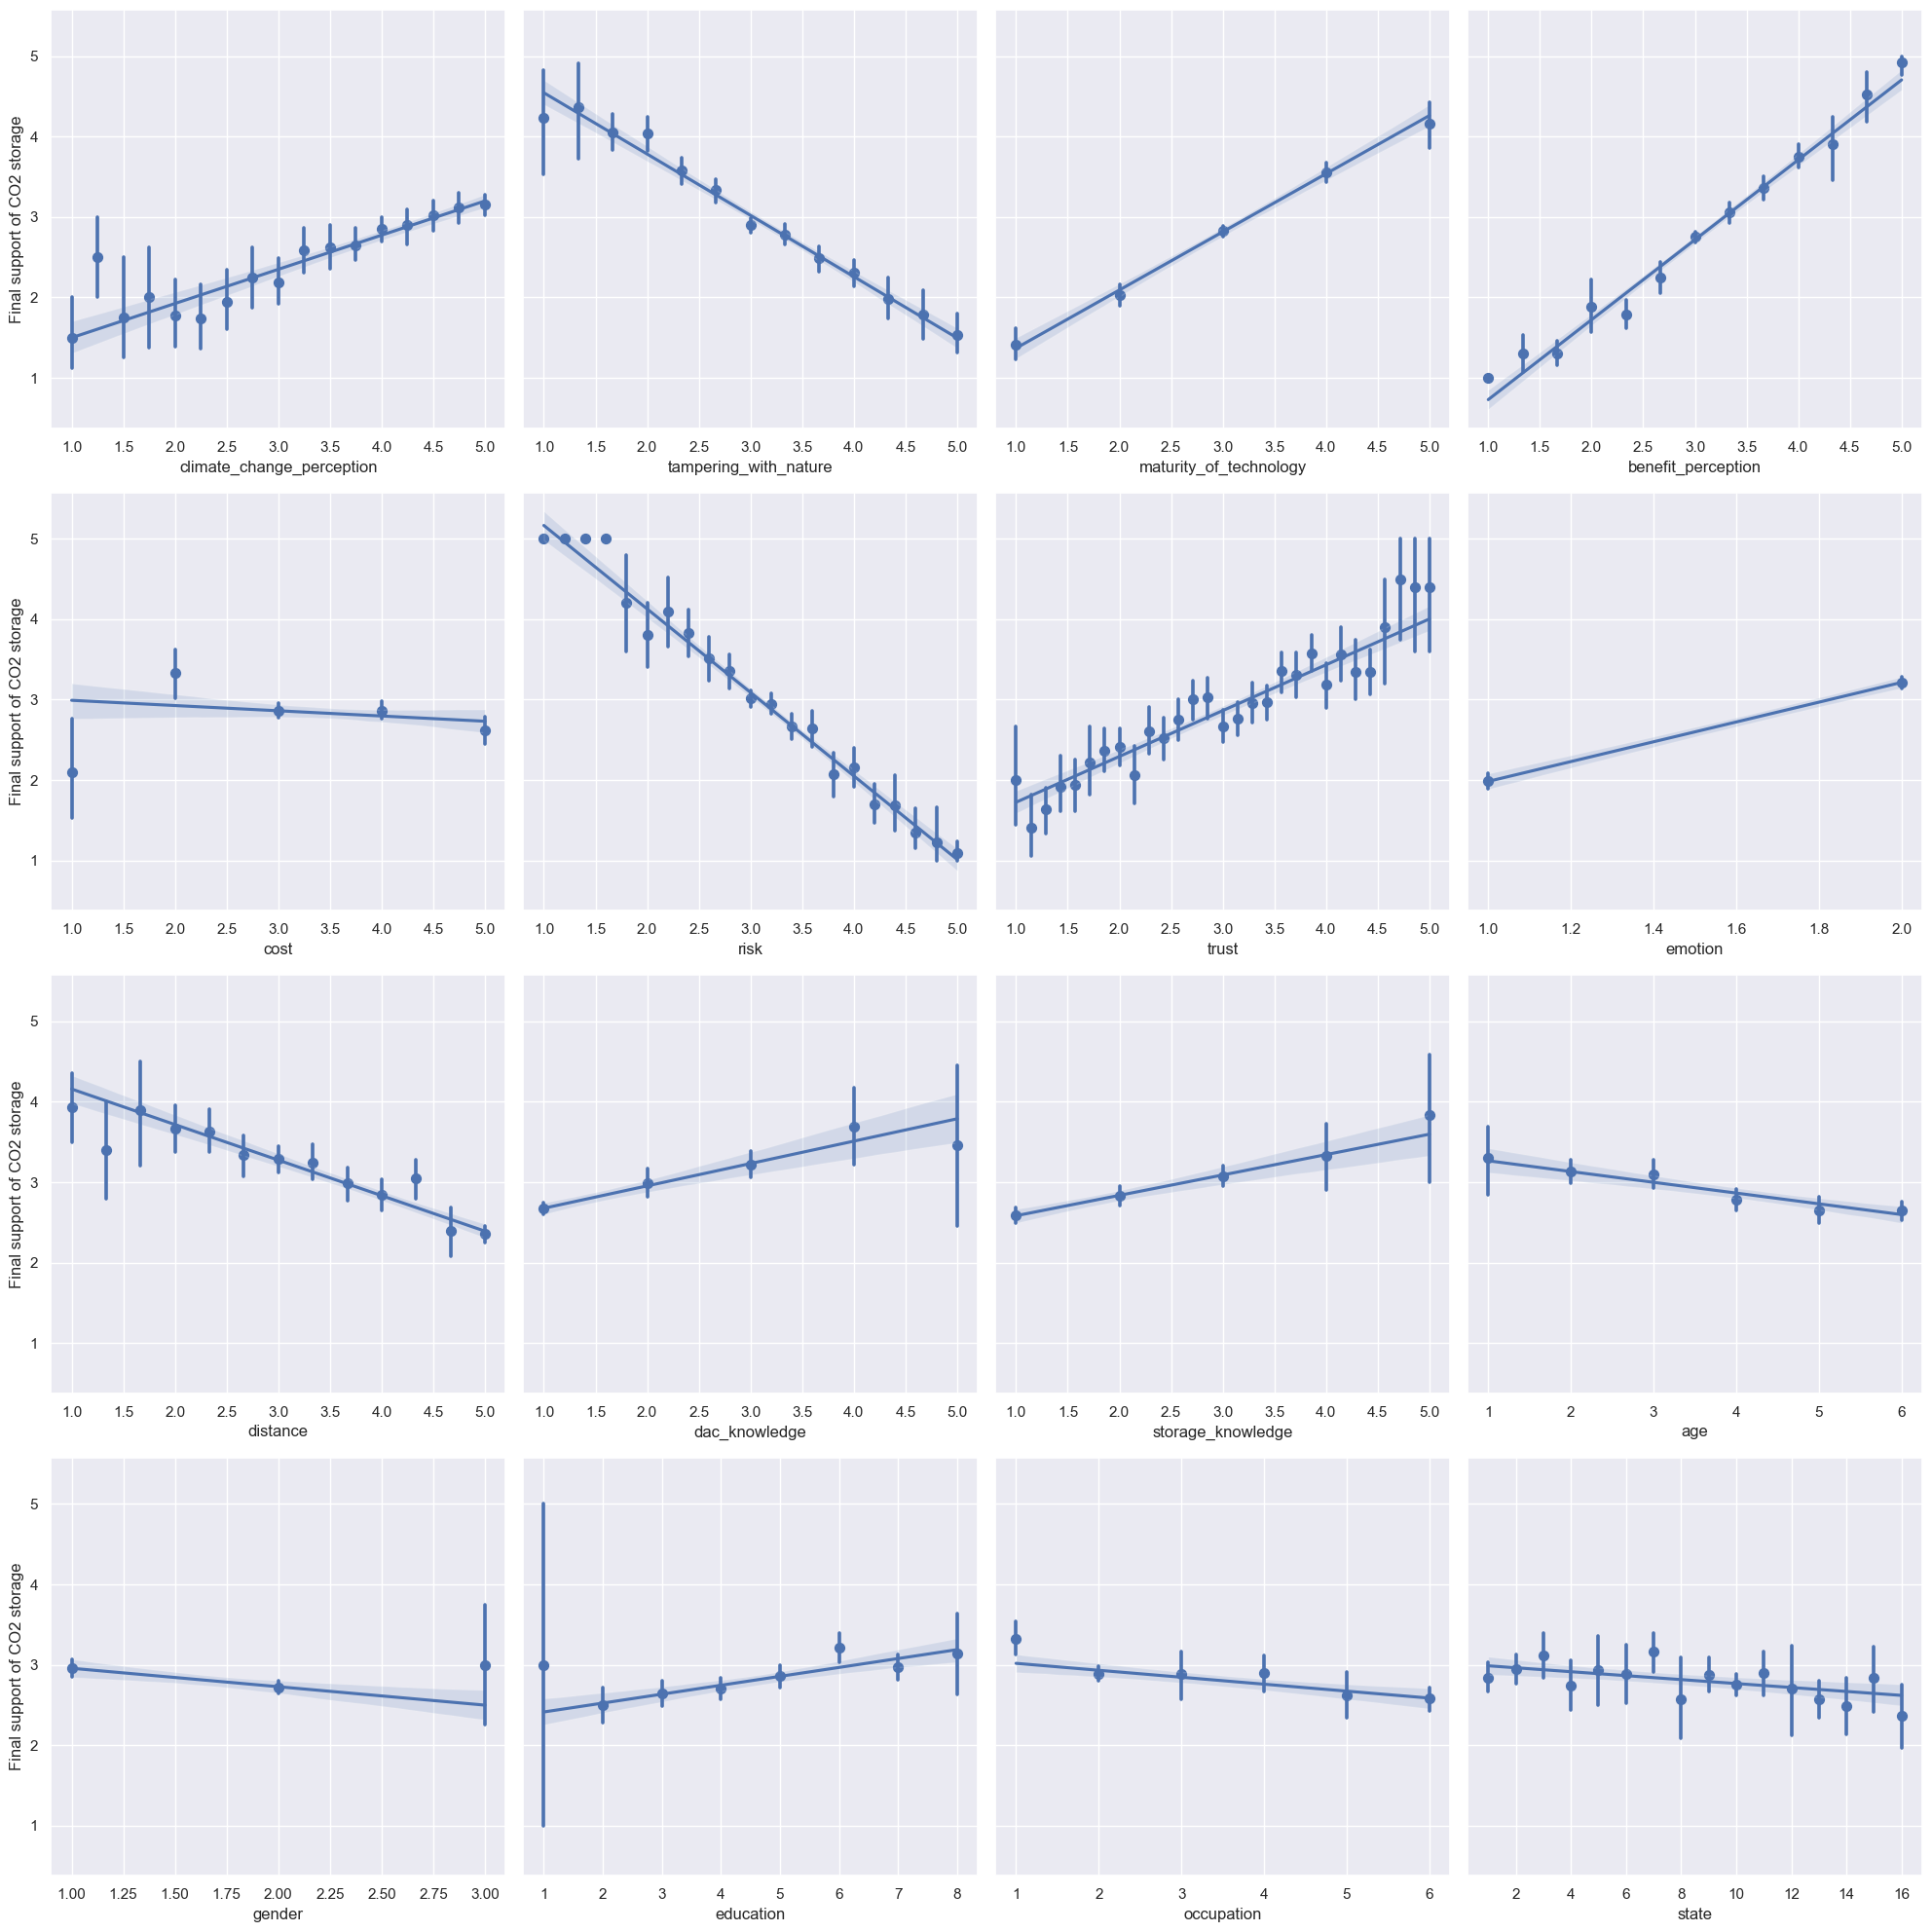

In [25]:
# Create a 4x4 panel plot
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharex=False, sharey=True)
axes = axes.flatten()

# Plot each scatter plot in the grid
for i, column in enumerate(X.columns):
    sns.regplot(
        y=df["final_storage_support"], x=df[column], x_estimator=np.mean, ax=axes[i]
    )
    if i % 4 == 0:
        axes[i].set_ylabel("Final support of CO2 storage")
    else:
        axes[i].set_ylabel(None)

plt.tight_layout()
fig.savefig("../results/co2_storage/final_storage_support_dependencies.png")
plt.show()
plt.close()

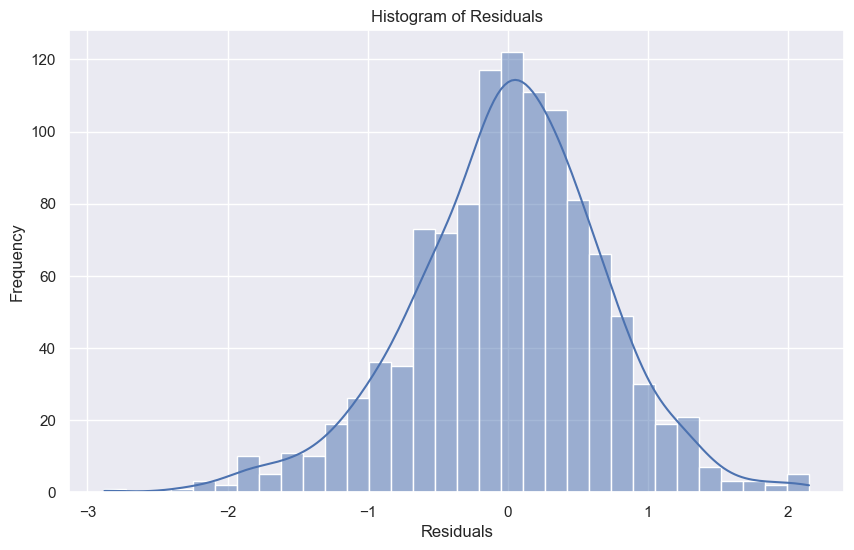

<Figure size 1000x600 with 0 Axes>

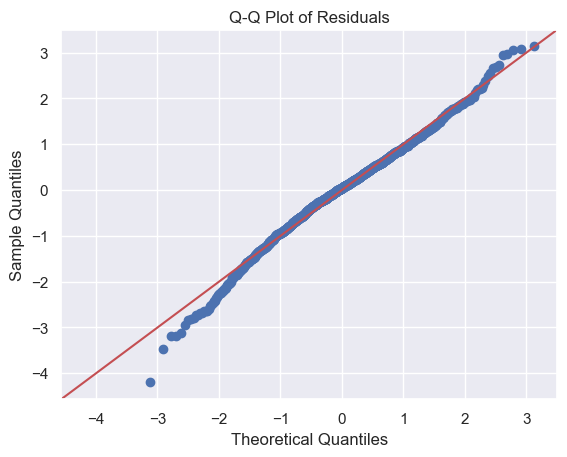

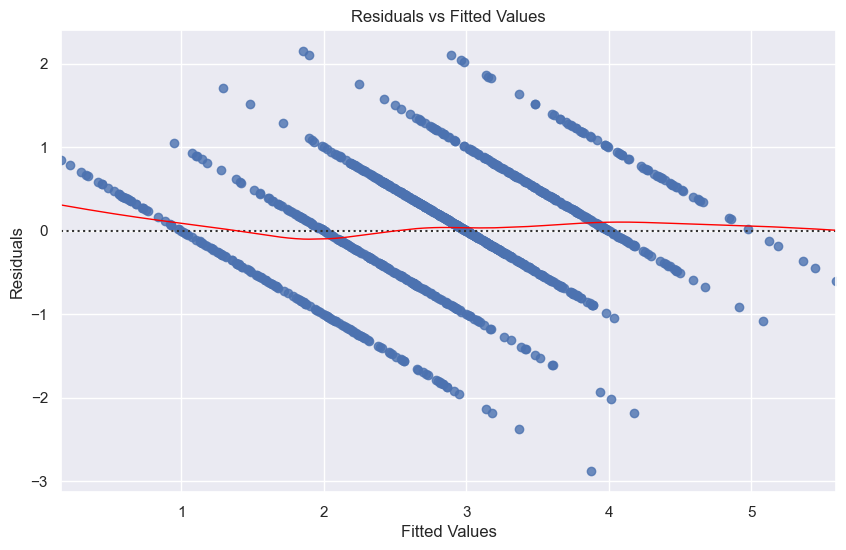

In [26]:
# Extract residuals
residuals = model.resid

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()
plt.savefig("../results/co2_storage/residuals_histogram.png")
plt.close()

# Plot Q-Q plot of residuals
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line="45", fit=True)
plt.title("Q-Q Plot of Residuals")
plt.savefig("../results/co2_storage/residuals_qq.png")
plt.show()
plt.close()

# Plot residuals vs fitted values
fitted_values = model.fittedvalues
plt.figure(figsize=(10, 6))
sns.residplot(
    x=fitted_values, y=residuals, lowess=True, line_kws={"color": "red", "lw": 1}
)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.savefig("../results/co2_storage/residuals_vs_fitted.png")
plt.show()
plt.close()